# Teste Data Science Elo7

### Descrição do Problema

Construir um classificador de produtos que recebe um conjunto de características de um produto e retorna a categoria dele.

### Dataset

Em resumo, o dataset contém 38.507 registros distribuídos em 5 categorias (Bebê, Bijuterias e Jóias, Decoração, Lembrancinhas, Papel e Cia e Outros). Cada registro corresponde a um clique em um produto a partir de um termo de busca no site.

Nesse dataset você encontrará as seguintes colunas:

 - product_id - identificação de produto
 - seller_id - identificação do vendedor
 - query - termo de busca inserido pelo usuário
 - search_page - número da página que o produto apareceu nos resultados de busca (mín 1 e máx 5)
 - position - número da posição que o produto apareceu dentro da página de busca (mín 0 e máx 38)
 - title - título do produto
 - concatenated_tags - tags do produto inseridas pelo vendedor (as tags estão concatenadas por espaço)
 - creation_date - data de criação do produto na plataforma do Elo7
 - price - preço do produto em reais
 - weight - peso em gramas da unidade do produto reportado pelo vendedor
 - express_delivery - indica se o produto é pronta entrega (1) ou não (0)
 - minimum_quantity - quantidade de unidades mínima necessária para compra
 - view_counts - número de cliques no produto nos últimos três meses
 - order_counts - número de vezes que o produto foi comprado nos últimos três meses
 - category - categoria do produto

# Importando as Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report

In [2]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

# Leitura dos Dados

In [3]:
dados = pd.read_csv('elo7_recruitment_dataset.csv')
dados.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [4]:
print('O conjunto de dados possui ',dados.shape[0],'linhas e ',dados.shape[1],'colunas.')

O conjunto de dados possui  38507 linhas e  15 colunas.


# Limpeza e Tratamento dos Dados

In [5]:
dados.dtypes

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts         float64
category              object
dtype: object

In [6]:
dados.isnull().sum()

product_id               0
seller_id                0
query                    0
search_page              0
position                 0
title                    0
concatenated_tags        2
creation_date            0
price                    0
weight                  58
express_delivery         0
minimum_quantity         0
view_counts              0
order_counts         20390
category                 0
dtype: int64

A coluna 'order_counts' apresenta muitos valores nulos (NaN). Essa coluna informa o número de compras do produto nos últimos três meses, e portanto posso assumir que representem produtos que não foram comprados no período. Esses valores serão substituídos por zero. 

In [7]:
dados.loc[dados['order_counts'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração
5,4336889,3436479,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,49.970000,208.0,1,1,1093,NaN,Lembrancinhas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38498,2739553,7358636,polaina tricot,1,0,Polainas em Tricô,polainas,2013-07-15 16:58:47,55.870000,0.0,0,1,176,NaN,Bebê
38501,9920560,5631760,lembrancinhas para mulheres,1,0,Lembrancinha Chá de Mulheres,lembrancas lembrancinhas lembrancinha cha mulh...,2018-02-21 10:51:06,14.510000,10.0,0,14,535,NaN,Lembrancinhas
38504,972256,4840665,copo metalizado,1,3,Copos Metalizados - Rosé,despedida bianca metalizados xvdakaw lembranci...,2018-02-17 15:53:23,11.580000,25.0,1,104,306,NaN,Lembrancinhas
38505,7291315,6420917,festa do pijama menino,1,36,Kit Festa do Pijama Meninos,festa pijama,2016-08-21 22:33:59,131.330000,0.0,1,11,55,NaN,Lembrancinhas


In [8]:
dados.loc[dados['order_counts']==0.0]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category


In [4]:
dados['order_counts'] = dados['order_counts'].fillna(0)

In [10]:
dados.isnull().sum()

product_id            0
seller_id             0
query                 0
search_page           0
position              0
title                 0
concatenated_tags     2
creation_date         0
price                 0
weight               58
express_delivery      0
minimum_quantity      0
view_counts           0
order_counts          0
category              0
dtype: int64

Existem 58 dados nulos na coluna 'weight'.Como são poucos dados em relação ao número total de dados do conjunto, podemos excluir esses dados.

In [11]:
dados.loc[dados['weight'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
1764,15179518,2520540,sabonete,2,30,Sabonete líquido,sabonete sabonete liquido maternidade,2010-02-23 08:55:19,3.200000,NaN,0,15,104,0.0,Outros
2321,16688789,9060983,kit homenageados 15 anos,1,29,Kit homenageados pink e branco,15 anos,2012-10-28 21:16:10,24.310000,NaN,1,4,34,0.0,Lembrancinhas
2477,10145823,1417817,lembrancinha de casamento,4,15,lembrancinha de casamento,lembrancinhas,2012-08-07 21:05:36,14.030000,NaN,0,0,232,0.0,Lembrancinhas
4038,9797453,6000437,saco roupa suja,1,15,Saco para roupa suja,saco roupa suja,2011-09-01 05:44:28,35.340000,NaN,0,4,8,0.0,Outros
4115,10807030,139807,convite 90 anos,1,26,CONVITE DE 90 ANOS,convites personalizados 10x15,2012-09-23 09:43:45,12.060000,NaN,1,15,48,0.0,Papel e Cia
5257,12242119,431519,cartao de agradecimento cha de fraldas,1,3,TAG/MINI CARTÃO - CHÁ DE FRALDAS,bebes tags cartoes,2010-07-27 16:59:18,9.870000,NaN,1,34,104,0.0,Papel e Cia
5892,3301068,3058025,lembrancinha de maternidade diferente,1,12,"Lembrancinhas, aniversário, maternidade",lembrancinhas maternidade tata bloquinhos lemb...,2012-07-28 12:31:23,15.000000,NaN,1,24,962,0.0,Bebê
6532,12775302,10020204,cartao dia dos pais,1,2,Cartão Dia dos Pais,cartoes,2012-08-10 14:56:30,12.190000,NaN,1,0,228,0.0,Papel e Cia
7034,13613187,546025,tapete para banheiro de barbante,1,19,Tapetes de Barbantes,tapetes barbante decoracao tapete barbante,2012-05-28 10:12:27,243.340000,NaN,1,0,95,0.0,Decoração
7307,11038478,7879862,lembranca,1,37,LEMBRANÇA DE CASAMENTO,009 casamento lembranca casamento casamento,2011-03-29 17:01:00,12.950000,NaN,1,22,227,0.0,Outros


O mesmo raciocínio adotado para tratar os valores nulos da coluna 'weight' pode ser adotado para a coluna 'concatenated_tags', que tem apenas 2 valores nulos.

In [12]:
dados.loc[dados['concatenated_tags'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
6359,9247896,8344716,stranger things,2,30,Caixinha Stranger Things,NaN,2018-06-01 23:13:18,62.9,329.0,1,5,121,10.0,Decoração
29809,8132534,6790389,prateleira para gatos,1,5,Kit Ponte Passarela para Gatos com 2 prateleiras,NaN,2018-03-28 15:29:07,107.8,3808.0,0,1,202,7.0,Outros


In [5]:
dados.dropna(inplace=True)

In [14]:
dados.isnull().sum()

product_id           0
seller_id            0
query                0
search_page          0
position             0
title                0
concatenated_tags    0
creation_date        0
price                0
weight               0
express_delivery     0
minimum_quantity     0
view_counts          0
order_counts         0
category             0
dtype: int64

In [15]:
print('O conjunto de dados possui ',dados.shape[0],'linhas e ',dados.shape[1],'colunas após excluirmos os valores nulos.')

O conjunto de dados possui  38447 linhas e  15 colunas após excluirmos os valores nulos.


In [16]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38447 entries, 0 to 38506
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         38447 non-null  int64  
 1   seller_id          38447 non-null  int64  
 2   query              38447 non-null  object 
 3   search_page        38447 non-null  int64  
 4   position           38447 non-null  int64  
 5   title              38447 non-null  object 
 6   concatenated_tags  38447 non-null  object 
 7   creation_date      38447 non-null  object 
 8   price              38447 non-null  float64
 9   weight             38447 non-null  float64
 10  express_delivery   38447 non-null  int64  
 11  minimum_quantity   38447 non-null  int64  
 12  view_counts        38447 non-null  int64  
 13  order_counts       38447 non-null  float64
 14  category           38447 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 4.7+ MB


# Análise Exploratória

Essa parte consiste na exploração dos dados, com o objetivo de conhecer os dados e tirar algumas informações que podem ser importantes para o sistema de classificação.

### Estatísticas Descritivas

In [17]:
dados.describe()

,product_id,seller_id,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts
count,3.844700e+04,3.844700e+04,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000
mean,8.341086e+06,5.009940e+06,1.491690,16.892918,84.122273,361.747965,0.780555,14.603766,545.986397,12.901709
std,4.835196e+06,2.947308e+06,0.980153,11.589345,211.952413,1820.777260,0.413876,43.800200,1417.489218,43.743231
min,3.610000e+02,8.170000e+02,1.000000,0.000000,0.070000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4.137908e+06,2.473568e+06,1.000000,6.000000,12.760000,6.000000,1.000000,3.000000,119.000000,0.000000
50%,8.371889e+06,4.917720e+06,1.000000,16.000000,28.529999,9.000000,1.000000,7.000000,243.000000,0.000000
75%,1.252850e+07,7.638876e+06,2.000000,27.000000,90.000000,107.000000,1.000000,16.000000,521.000000,14.000000
max,1.669295e+07,1.011887e+07,5.000000,38.000000,11509.380000,65009.000000,1.000000,3000.000000,45010.000000,2460.000000


A função 'describe' mostra algumas informações estatísticas sobre as variáveis numéricas. Temos a contagem de variáveis, o valor da média de cada variável, o desvio padrão, o valor mínimo e máximo, o percentil inferior e superior (25% e 75%) e o percentil de 50% que é o mesmo que a mediana.

Quantos valores unicos existem em cada coluna do conjunto de dados?

In [18]:
dados.nunique()

product_id           29748
seller_id             8504
query                 6395
search_page              5
position                39
title                25319
concatenated_tags    22981
creation_date        29742
price                15039
weight                1195
express_delivery         2
minimum_quantity       164
view_counts           3100
order_counts           353
category                 6
dtype: int64

Quantos produtos possuem pronta entrega e quantos não? Qual a porcentagem que isso representa?

In [19]:
dados['express_delivery'].value_counts()

1    30010
0     8437
Name: express_delivery, dtype: int64

In [20]:
dados['express_delivery'].value_counts()/dados.shape[0]

1    0.780555
0    0.219445
Name: express_delivery, dtype: float64

A maioria dos produtos (78%) estão disponíveis a pronta entrega.

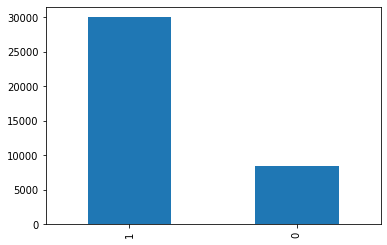

In [21]:
dados['express_delivery'].value_counts().plot(kind='bar')

Quantos registros há em cada categoria? Qual a porcentagem que isso representa?

In [22]:
dados['category'].value_counts()

Lembrancinhas         17746
Decoração              8836
Bebê                   7015
Papel e Cia            2762
Outros                 1137
Bijuterias e Jóias      951
Name: category, dtype: int64

In [23]:
dados['category'].value_counts()/dados.shape[0]

Lembrancinhas         0.461570
Decoração             0.229823
Bebê                  0.182459
Papel e Cia           0.071839
Outros                0.029573
Bijuterias e Jóias    0.024735
Name: category, dtype: float64

O conjunto de dados é composto por 6 categorias, sendo a maior parte dos registros, 46,15%, pertence a categoria de Lembrancinhas, 23% pertence a categoria de Decoração e 18,24% a categoria de Bebê. Essas 3 categorias representam a maior parte do conjunto de dados. As outras 3 categorias representam a menor porcentagem dos dados, a categoria Papel e Cia possui 7,1% dos dados, Bijuteria e Jóias 3% e 2,47% estão na categoria Outros.

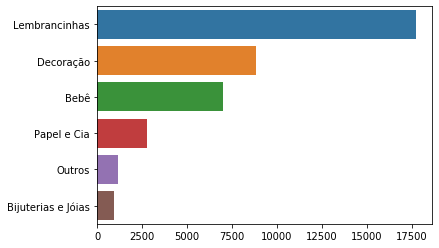

In [24]:
sns.barplot(dados['category'].value_counts().values,dados['category'].value_counts().index)

Quantos vendedores existem em cada categoria?

In [25]:
dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False)

category
Lembrancinhas         3178
Decoração             2762
Bebê                  2034
Papel e Cia            957
Outros                 515
Bijuterias e Jóias     363
Name: seller_id, dtype: int64

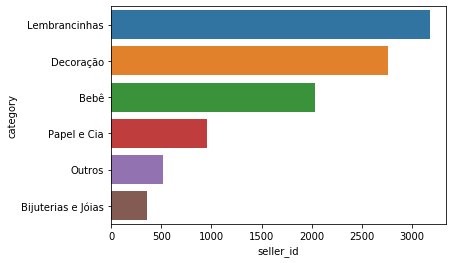

In [26]:
sns.barplot(dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False),
            dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False).index)

Quantos produtos existem em cada categoria?

In [27]:
dados.groupby('category')['product_id'].nunique().sort_values(ascending=False)

category
Lembrancinhas         12759
Decoração              7382
Bebê                   5442
Papel e Cia            2288
Outros                 1014
Bijuterias e Jóias      863
Name: product_id, dtype: int64

Como é a distribuição da variável preço?

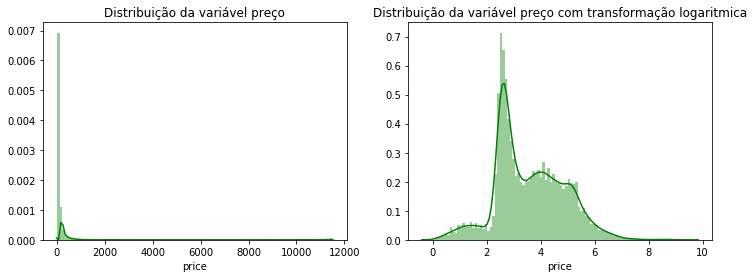

In [28]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['price'], color='g', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.log1p(dados['price']), color='g', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável preço')
axs[1].set_title('Distribuição da variável preço com transformação logaritmica')
plt.show()

#### BoxPlot

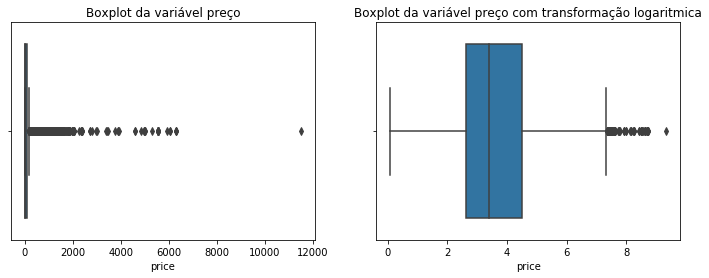

In [29]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(dados['price'],ax=axs[0])
sns.boxplot(np.log1p(dados['price']),ax=axs[1])
axs[0].set_title('Boxplot da variável preço')
axs[1].set_title('Boxplot da variável preço com transformação logaritmica')
plt.show()

In [30]:
dados['price'].describe()

count    38447.000000
mean        84.122273
std        211.952413
min          0.070000
25%         12.760000
50%         28.529999
75%         90.000000
max      11509.380000
Name: price, dtype: float64

In [31]:
dados.query('price == 11509.38')

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
15533,6003202,1308482,bebe reborn silicone solido,1,5,Boneca bebê de silicone sólido ecoflex Coral,rutimara aparecida pereira,2018-11-21 23:38:58,11509.38,8.0,0,5,1597,0.0,Bebê


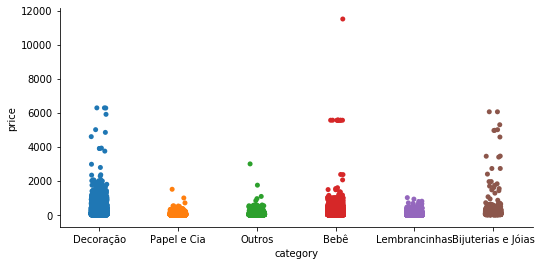

In [32]:
ax = sns.catplot(x='category', y='price',data=dados, aspect=2, height=3.8)

In [33]:
dados.groupby('category')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,7015.0,146.082603,287.879231,0.35,42.455000,99.680000,179.2250,11509.3800
Bijuterias e Jóias,951.0,198.781597,534.929273,2.99,41.014999,89.740000,171.2050,6060.1997
Decoração,8836.0,157.039922,272.178078,0.18,46.090000,80.899994,169.0525,6289.4200
Lembrancinhas,17746.0,24.454333,42.501799,0.12,10.840000,13.550000,19.9000,1017.6000
Outros,1137.0,64.077916,138.220691,0.15,15.000000,30.410000,62.5100,2998.7100
Papel e Cia,2762.0,45.622860,64.845306,0.07,11.100000,25.135000,59.7725,1508.9400


Como é a distribuição da variável peso?

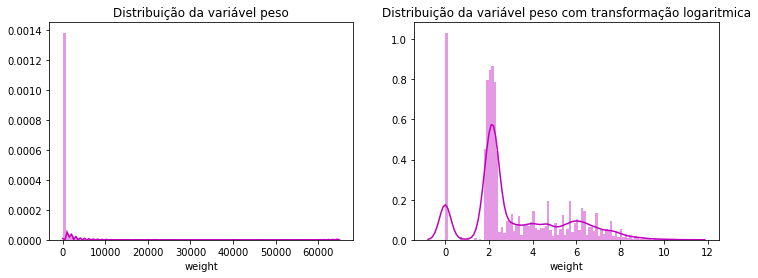

In [34]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['weight'], color='m', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.log1p(dados['weight']), color='m', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável peso')
axs[1].set_title('Distribuição da variável peso com transformação logaritmica')
plt.show()

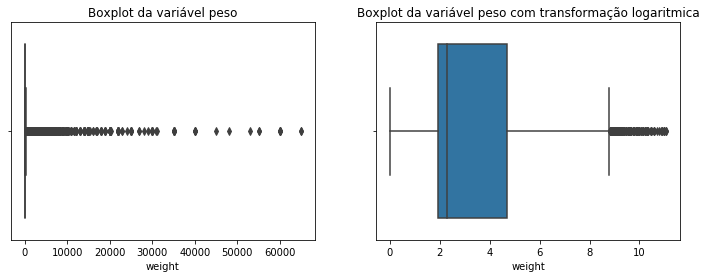

In [35]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(dados['weight'],ax=axs[0])
sns.boxplot(np.log1p(dados['weight']),ax=axs[1])
axs[0].set_title('Boxplot da variável peso')
axs[1].set_title('Boxplot da variável peso com transformação logaritmica')
plt.show()

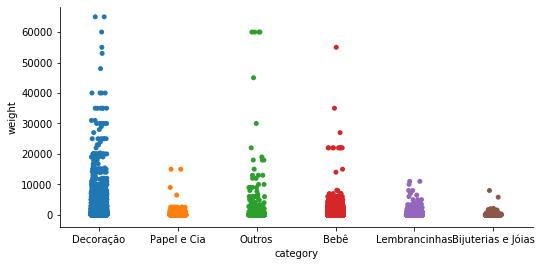

In [36]:
ax = sns.catplot(x='category', y='weight',data=dados, aspect=2, height=3.8)

In [37]:
dados.groupby('category')['weight'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,7015.0,394.424804,1425.323738,0.0,6.0,9.0,209.0,55007.0
Bijuterias e Jóias,951.0,61.232387,366.584620,0.0,6.0,9.0,19.0,8006.0
Decoração,8836.0,989.146446,3091.792320,0.0,7.0,156.0,712.0,65009.0
Lembrancinhas,17746.0,63.299560,277.027696,0.0,6.0,9.0,29.0,11006.0
Outros,1137.0,765.503078,4296.793777,0.0,7.0,10.0,175.0,60009.0
Papel e Cia,2762.0,126.434830,538.097324,0.0,6.0,8.0,30.0,15007.0


Existem muitos dados com peso igual a zero, a qual categoria esses dados pertencem?

In [6]:
peso_zero = dados.loc[dados['weight']==0.0]

In [39]:
peso_zero.groupby('category')['weight'].value_counts()

category            weight
Bebê                0.0        862
Bijuterias e Jóias  0.0        113
Decoração           0.0        766
Lembrancinhas       0.0       2213
Outros              0.0        101
Papel e Cia         0.0        343
Name: weight, dtype: int64

In [7]:
dados.drop(peso_zero.index,axis=0,inplace=True)

Quais produtos tiveram os maiores números de cliques nos ultimos 3 meses? A qual categoria esses produtos pertencem?

In [41]:
dados.groupby('category')['view_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,6153.0,734.769381,2239.309129,1.0,142.00,300.0,644.00,41544.0
Bijuterias e Jóias,838.0,531.980907,1300.376850,1.0,82.25,185.0,394.75,18246.0
Decoração,8070.0,434.818340,1212.381671,1.0,102.00,200.0,418.00,45010.0
Lembrancinhas,15533.0,564.600270,1229.851785,1.0,128.00,265.0,570.00,31372.0
Outros,1036.0,497.423745,979.101630,2.0,101.00,196.5,431.25,8408.0
Papel e Cia,2419.0,439.622571,953.886960,3.0,99.00,193.0,437.00,17332.0


Como é a distribuição da variável quantidade mínima?

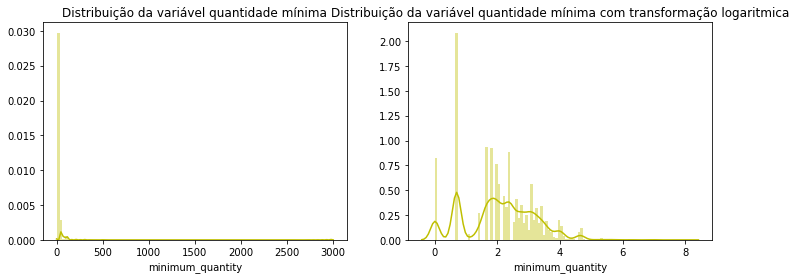

In [42]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['minimum_quantity'], color='y', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.log1p(dados['minimum_quantity']), color='y', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável quantidade mínima')
axs[1].set_title('Distribuição da variável quantidade mínima com transformação logaritmica')
plt.show()

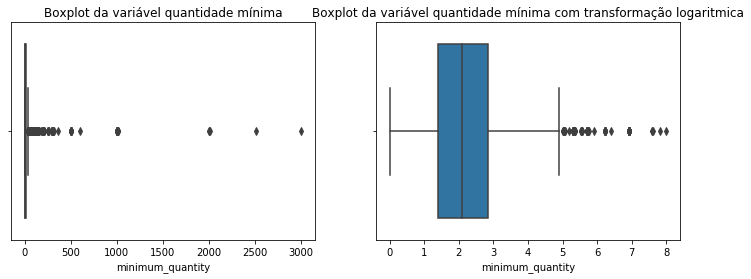

In [43]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(dados['minimum_quantity'],ax=axs[0])
sns.boxplot(np.log1p(dados['minimum_quantity']),ax=axs[1])
axs[0].set_title('Boxplot da variável quantidade mínima')
axs[1].set_title('Boxplot da variável quantidade mínima com transformação logaritmica')
plt.show()

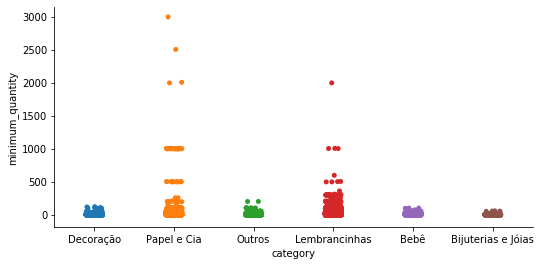

In [44]:
ax = sns.catplot(x='category', y='minimum_quantity',data=dados, aspect=2, height=3.8)

In [45]:
dados.groupby('category')['minimum_quantity'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,6153.0,6.319356,7.894825,0.0,1.0,5.0,8.0,104.0
Bijuterias e Jóias,838.0,4.373508,5.169769,0.0,1.0,4.0,7.0,61.0
Decoração,8070.0,4.671128,5.911471,0.0,1.0,4.0,7.0,125.0
Lembrancinhas,15533.0,21.629563,33.922575,0.0,8.0,15.0,25.0,2000.0
Outros,1036.0,7.361004,15.273196,0.0,1.0,4.0,8.0,204.0
Papel e Cia,2419.0,30.125672,139.632298,0.0,1.0,7.0,19.0,3000.0


Como é a distribuição da variável 'order_counts' (número de vezes que o produto foi comprado nos últimos três meses)?

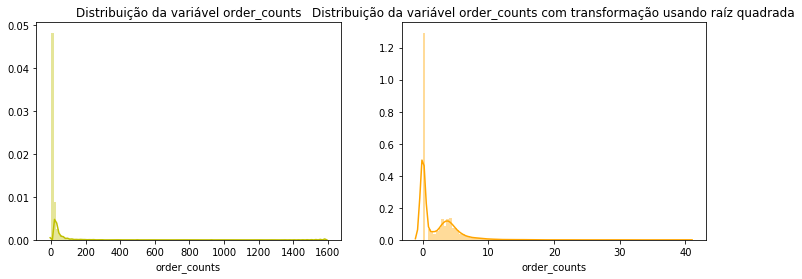

In [46]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['order_counts'], color='y', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.sqrt(dados['order_counts']), color='orange', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável order_counts')
axs[1].set_title('Distribuição da variável order_counts com transformação usando raíz quadrada')
plt.show()

In [47]:
dados['query'].value_counts()

bolsa maternidade               135
dia dos pais                    122
porta maternidade               110
batizado                        110
lembrancinha                    110
                               ... 
caixa bala                        1
aquarela                          1
porta kit kat luxo                1
porta doces                       1
decoracao cha de bebe baloes      1
Name: query, Length: 6199, dtype: int64

In [48]:
dados['concatenated_tags'].value_counts()

dia pais                                                                                     708
lembrancinhas                                                                                172
batizado                                                                                      99
tapetes                                                                                       78
decoracao                                                                                     67
                                                                                            ... 
polaroids                                                                                      1
lembrancinhas flores folhas cha cozinha doceria suculentas diversos                            1
caneta lembrancinhas dia pais lembrancinhas mimos                                              1
chaveiro feltro lembrancinhas feltro                                                           1
coisas colecao classica pontil

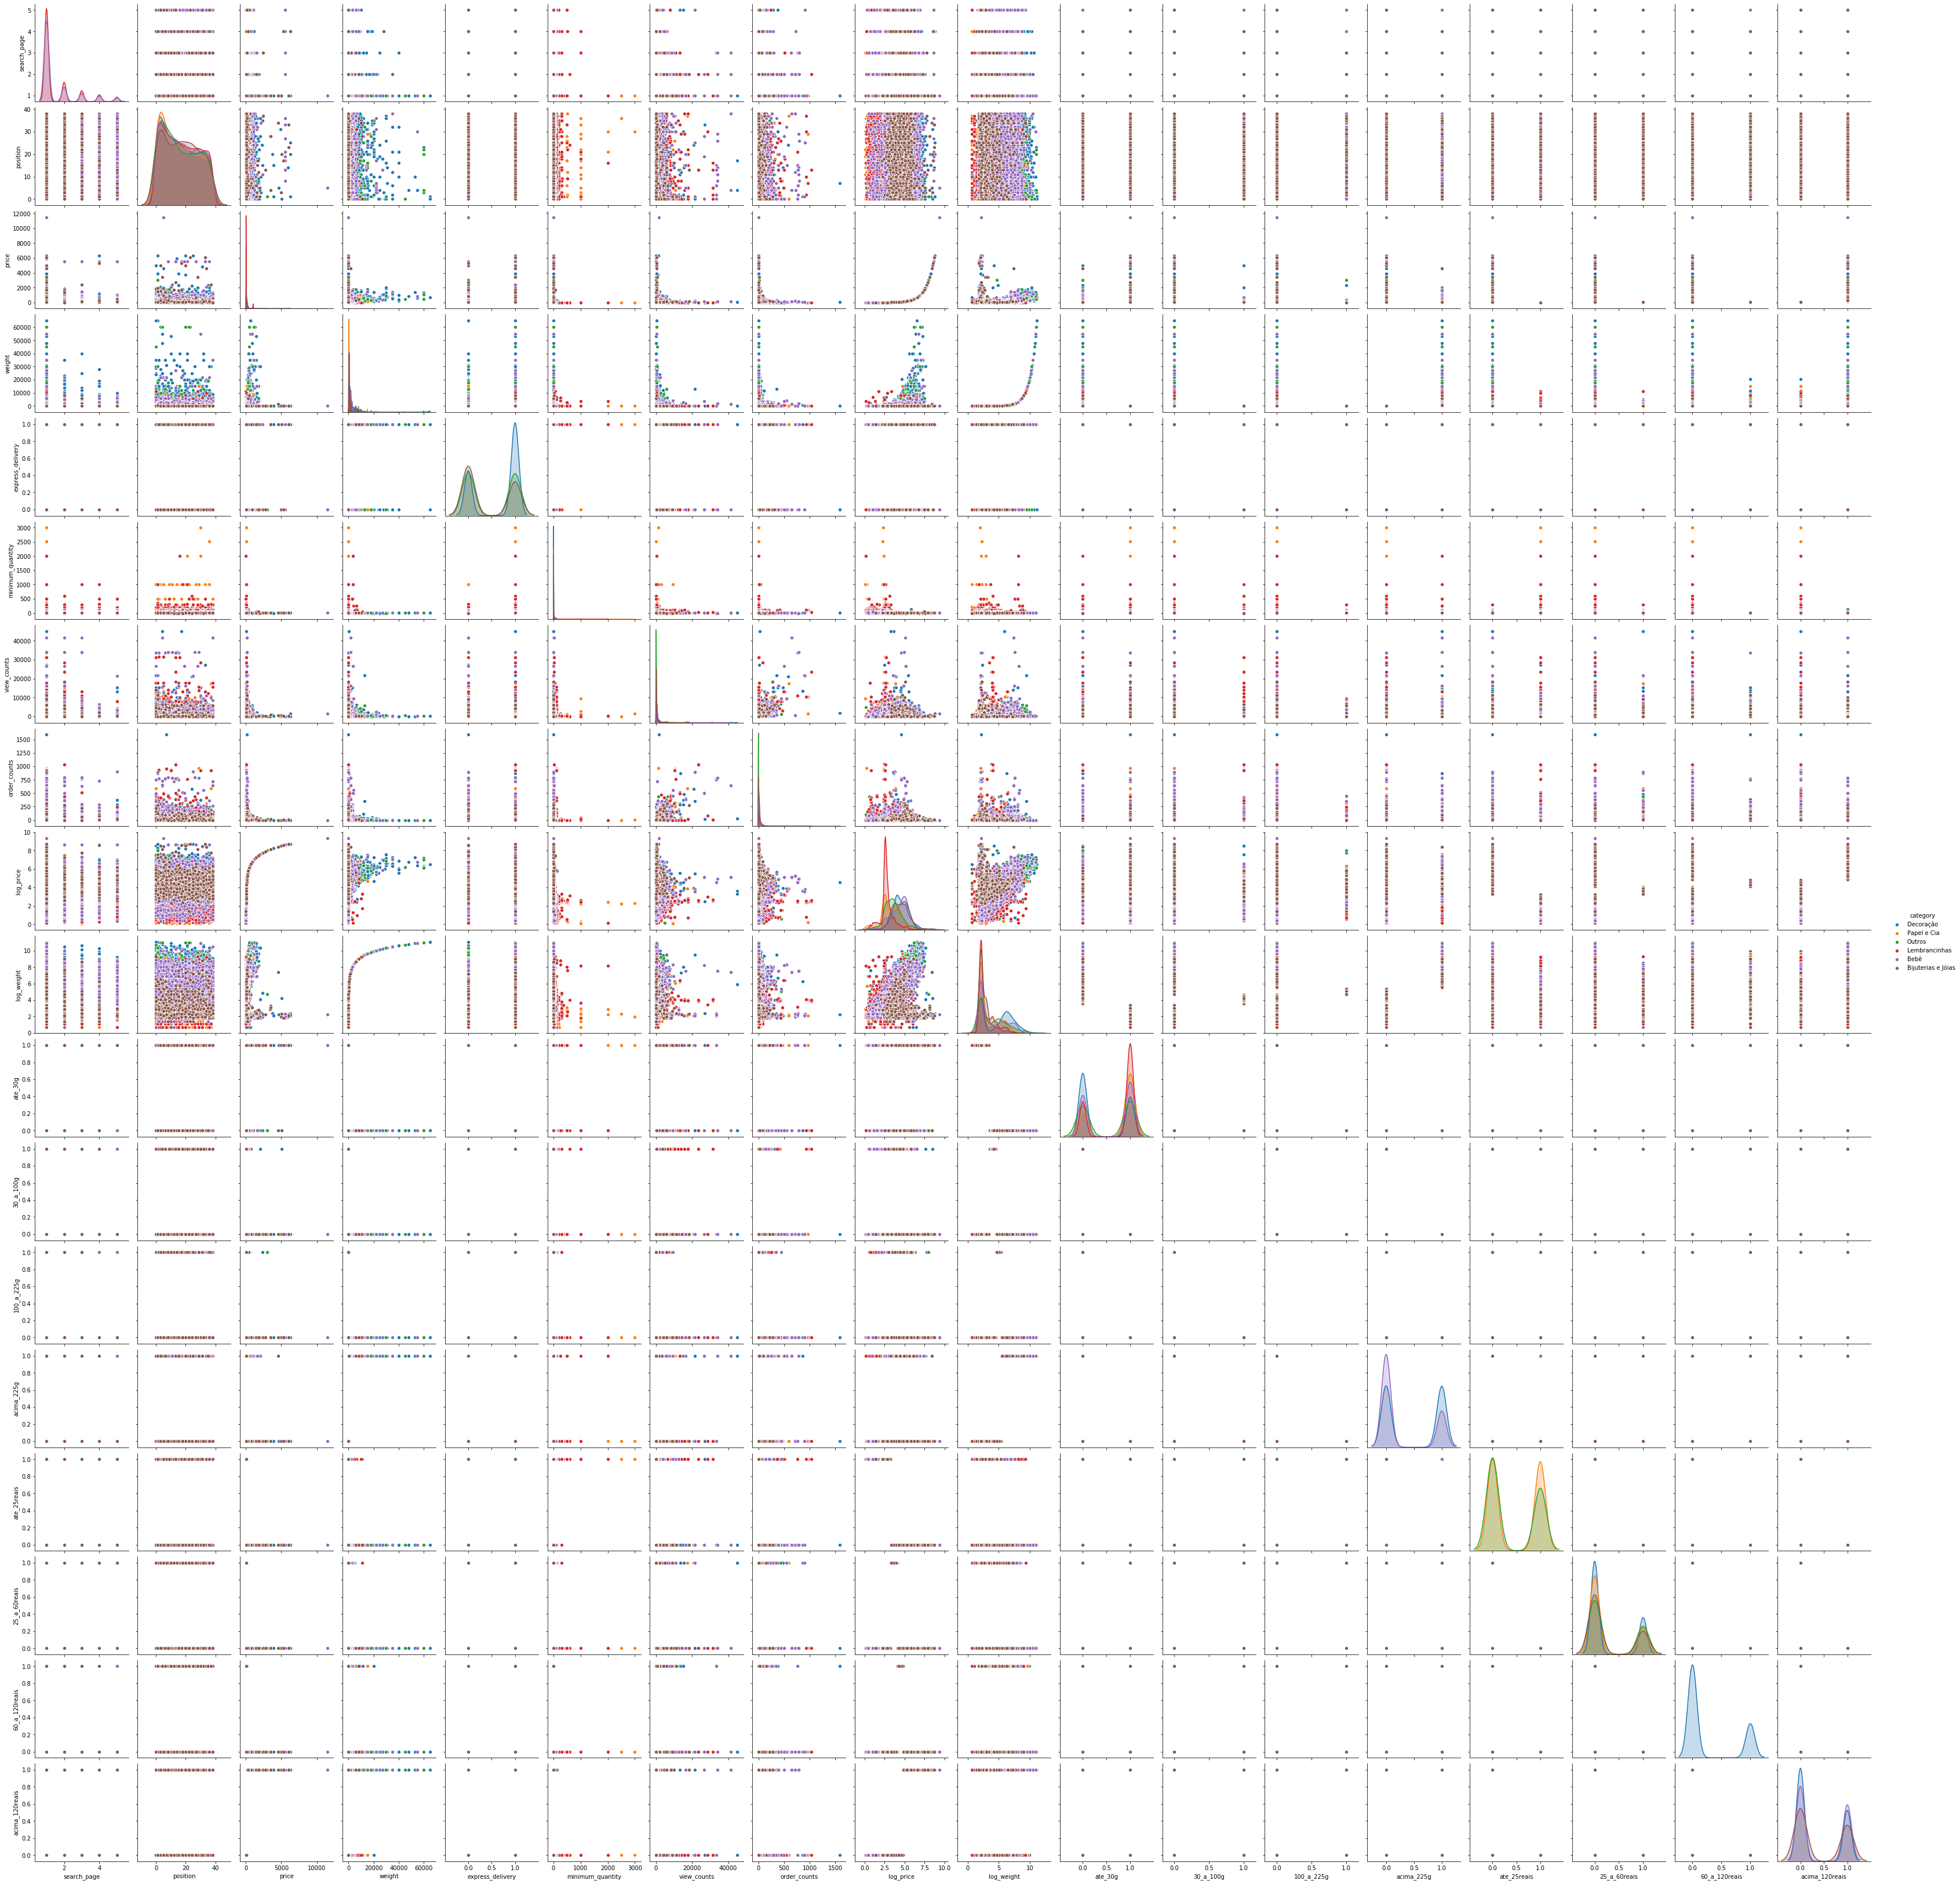

In [26]:
sns.pairplot(dados,hue='category')

## Feature Engineering

In [8]:
dados['log_price'] = np.log1p(dados['price'])
dados['log_weight'] = np.log1p(dados['weight'])

In [9]:
dados.loc[dados['weight'] <= 30.0, 'ate_30g'] = 1
dados.loc[(dados['weight'] > 30.0)&(dados['weight'] <= 100.0), '30_a_100g'] = 1
dados.loc[(dados['weight'] > 100.0)&(dados['weight'] <= 225.0), '100_a_225g'] = 1
dados.loc[dados['weight'] > 225.0, 'acima_225g'] = 1

In [10]:
dados.loc[dados['price'] <= 25.0, 'ate_25reais'] = 1
dados.loc[(dados['price'] > 25.0)&(dados['price'] <= 60.0), '25_a_60reais'] = 1
dados.loc[(dados['price'] > 60.0)&(dados['price'] <= 120.0), '60_a_120reais'] = 1
dados.loc[dados['price'] > 120.0, 'acima_120reais'] = 1

In [11]:
dados.fillna(0,inplace=True)

In [53]:
dados.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category,log_price,log_weight,ate_30g,30_a_100g,100_a_225g,acima_225g,ate_25reais,25_a_60reais,60_a_120reais,acima_120reais
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,0.0,Decoração,5.152656,7.090910,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,0.0,Papel e Cia,4.365262,2.197225,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,0.0,Outros,4.316421,7.904704,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,0.0,Decoração,5.261705,6.230481,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,4336889,3436479,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,49.970000,208.0,1,1,1093,0.0,Lembrancinhas,3.931237,5.342334,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Correlação entre as variáveis

Correlação entre variáveis é uma medida numerica que indica a relação estatística entre duas variáveis. No nosso problema, utilizaremos duas formas de calculo de correlação, a correlação de Pearson e a correlação de Spearman.

 - Correlação de Pearson: Mede o grau de correlação (e também a direção) entre duas variáveis. É utilizada para      medir relações lineares entre variáveis. A correlação será um valor numérico entre -1 e 1, sendo 1 uma            correlação perfeita positiva (se a variável aumenta, a outra aumenta também), 0 significa que as variáveis são    linearmente independentes, e -1 uma correlação negativa perfeita (se a variável aumenta a outra diminui).
 
 
 
 - Correlação de Spearman: Também mede o grau de correlação entre duas variáveis e sua direção, porém a relação      entre as variáveis pode ser não linear. 

In [12]:
dados.drop(['product_id','seller_id'],axis=1,inplace=True)

In [55]:
dados.corr()

,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,log_price,log_weight,ate_30g,30_a_100g,100_a_225g,acima_225g,ate_25reais,25_a_60reais,60_a_120reais,acima_120reais
search_page,1.000000,0.053006,-0.002287,-0.022631,0.029201,0.022142,-0.021571,-0.000711,-0.047690,-0.029326,0.024364,0.016723,-0.024827,-0.025187,0.079508,-0.058728,-0.053151,0.005026
position,0.053006,1.000000,-0.001709,-0.011441,0.002593,0.008103,-0.064933,-0.043330,-0.009235,-0.012316,0.011716,0.001944,-0.001055,-0.014455,0.018564,-0.012752,-0.021410,0.008230
price,-0.002287,-0.001709,1.000000,0.229079,-0.042714,-0.078923,-0.003366,-0.018182,0.565809,0.155463,-0.058089,-0.090386,-0.043427,0.158403,-0.321036,-0.098428,0.003704,0.498583
weight,-0.022631,-0.011441,0.229079,1.000000,-0.051836,-0.038941,0.012485,0.004995,0.277832,0.482295,-0.260693,-0.058682,-0.036268,0.369011,-0.176074,-0.051016,0.009969,0.263461
express_delivery,0.029201,0.002593,-0.042714,-0.051836,1.000000,0.085541,-0.017063,-0.049548,-0.152444,-0.140122,0.117116,0.028059,-0.056293,-0.122637,0.189394,-0.102821,-0.067325,-0.077356
minimum_quantity,0.022142,0.008103,-0.078923,-0.038941,0.085541,1.000000,0.032400,0.005548,-0.236134,-0.101212,0.082904,0.047255,-0.034910,-0.109170,0.235278,-0.100307,-0.095382,-0.112728
view_counts,-0.021571,-0.064933,-0.003366,0.012485,-0.017063,0.032400,1.000000,0.606538,-0.012446,0.026496,-0.030139,0.056222,-0.025621,0.011263,0.026845,-0.043281,-0.012035,0.019595
order_counts,-0.000711,-0.043330,-0.018182,0.004995,-0.049548,0.005548,0.606538,1.000000,-0.004659,0.066876,-0.066785,0.055660,-0.009292,0.044620,-0.011049,-0.008182,0.012047,0.011292
log_price,-0.047690,-0.009235,0.565809,0.277832,-0.152444,-0.236134,-0.012446,-0.004659,1.000000,0.378176,-0.237320,-0.195533,-0.000445,0.416375,-0.815831,0.049938,0.281591,0.728697
log_weight,-0.029326,-0.012316,0.155463,0.482295,-0.140122,-0.101212,0.026496,0.066876,0.378176,1.000000,-0.880405,0.072155,0.191564,0.863504,-0.366446,0.070280,0.156994,0.252930


In [56]:
dados.corr(method='spearman')

,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,log_price,log_weight,ate_30g,30_a_100g,100_a_225g,acima_225g,ate_25reais,25_a_60reais,60_a_120reais,acima_120reais
search_page,1.000000,0.059349,-0.061371,-0.024852,0.033304,0.081406,-0.031664,0.012663,-0.061371,-0.024852,0.025361,0.015913,-0.018838,-0.029441,0.086425,-0.062374,-0.054643,0.001233
position,0.059349,1.000000,-0.011387,-0.012420,0.002852,0.020912,-0.139870,-0.041739,-0.011387,-0.012420,0.011947,0.002289,-0.000910,-0.015057,0.019055,-0.013339,-0.021542,0.008307
price,-0.061371,-0.011387,1.000000,0.264611,-0.169019,-0.639974,-0.039017,0.091435,1.000000,0.264611,-0.263974,-0.200809,0.022873,0.437083,-0.864649,0.110124,0.332088,0.685905
weight,-0.024852,-0.012420,0.264611,1.000000,-0.119293,-0.213319,-0.008859,0.194659,0.264611,1.000000,-0.845433,0.181429,0.230458,0.721617,-0.260769,0.071630,0.122942,0.148665
express_delivery,0.033304,0.002852,-0.169019,-0.119293,1.000000,0.285307,0.038338,-0.089412,-0.169019,-0.119293,0.117116,0.028059,-0.056293,-0.122637,0.189394,-0.102821,-0.067325,-0.077356
minimum_quantity,0.081406,0.020912,-0.639974,-0.213319,0.285307,1.000000,0.099379,-0.100612,-0.639974,-0.213319,0.227499,0.148808,-0.070655,-0.328446,0.650989,-0.263878,-0.271493,-0.318650
view_counts,-0.031664,-0.139870,-0.039017,-0.008859,0.038338,0.099379,1.000000,0.323298,-0.039017,-0.008859,0.016165,0.047691,-0.031029,-0.033660,0.087927,-0.138299,-0.042342,0.063362
order_counts,0.012663,-0.041739,0.091435,0.194659,-0.089412,-0.100612,0.323298,1.000000,0.091435,0.194659,-0.175761,0.055100,0.049221,0.136947,-0.115235,0.028468,0.083464,0.042929
log_price,-0.061371,-0.011387,1.000000,0.264611,-0.169019,-0.639974,-0.039017,0.091435,1.000000,0.264611,-0.263974,-0.200809,0.022873,0.437083,-0.864649,0.110124,0.332088,0.685905
log_weight,-0.024852,-0.012420,0.264611,1.000000,-0.119293,-0.213319,-0.008859,0.194659,0.264611,1.000000,-0.845433,0.181429,0.230458,0.721617,-0.260769,0.071630,0.122942,0.148665


# Sistema de Classificação

O sistema de classificação desse problema é do tipo Multi classe, no qual não há apenas verdadeiro ou falso (binário), mas sim varias classes (Bebê Bijuteria e Jóias, Decoração, Lembrancinhas, Papel e Cia e Outros), totalizando 6 categorias. Primeiro atribuimos a variável X todas as features consideradas preditoras (caracteristicas usadas para descrever o produto) e a variável y que é a classe que queremos prever.

In [13]:
X = dados.drop(['query','title','concatenated_tags','creation_date','category'],axis=1)
y = dados['category'].map({'Bebê':1, 'Bijuterias e Jóias':2, 'Decoração':3, 'Lembrancinhas':4,
                           'Papel e Cia':5, 'Outros':6})

Usamos a função train_test_split para selecionar as amostras de treino (80% do conjunto de dados selecionados de forma aleatória) e as amostras de teste (20% do conjunto de dados).

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [59]:
y_train.value_counts()

4    12448
3     6443
1     4914
5     1938
6      831
2      665
Name: category, dtype: int64

In [60]:
y_test.value_counts()

4    3085
3    1627
1    1239
5     481
6     205
2     173
Name: category, dtype: int64

DADOS DESBALANCEADOS

## Estimando um modelo usando Random Forest

Random Forest é um modelo de machine learning que constrói uma floresta aleatória de árvore de decisão. Para construir as árvores da floresta, o conjunto de dados passa pela etapa de "Bagging (Bootstrap Aggregation)", onde varias amostras desse conjunto de dados são selecionadas de forma aleatória, sendo permitido a seleção de uma mesma amostra mais de uma vez. 

O passo seguinte, é construir uma árvore para cada subconjunto de dados selecionado, usando um subconjunto de features (colunas) também escolhidos de forma aleatória. Quando entramos com o conjunto de dados de teste, o modelo usa todas as árvores construidas para prever a classe da nova amostra. A classe que receber o maior numero de votos, será a classe resposta da previsão.

<img src='rf.png'>

In [61]:
rf = RandomForestClassifier(n_estimators = 1000,random_state = 42)

rf.fit(X_train,y_train)

y_predict_rf = rf.predict(X_test)
print('Random Forest Test Score : ',rf.score(X_test,y_test))

Random Forest Test Score :  0.6713656387665198


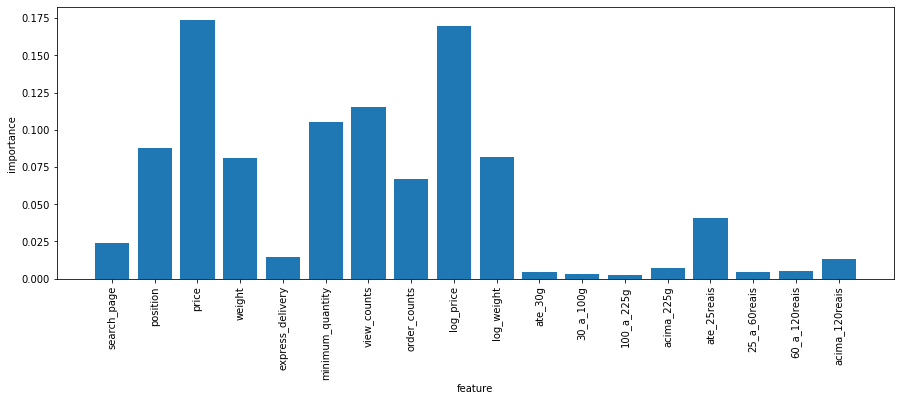

In [62]:
fig, axis = plt.subplots(figsize=(15, 5))
plot = axis.bar(X_train.columns, rf.feature_importances_)
plot = axis.set_xticklabels(X_train.columns.values, rotation='vertical')
plot = axis.set_xlabel('feature')
plot = axis.set_ylabel('importance')
plt.show()

In [63]:
lgbm = LGBMClassifier(n_estimators = 1000,learning_rate = 0.1, random_state = 42)

lgbm.fit(X_train,y_train)

y_predict_lgbm = lgbm.predict(X_test)

print('LGBM Score : ',lgbm.score(X_test,y_test))

LGBM Score :  0.6572687224669603


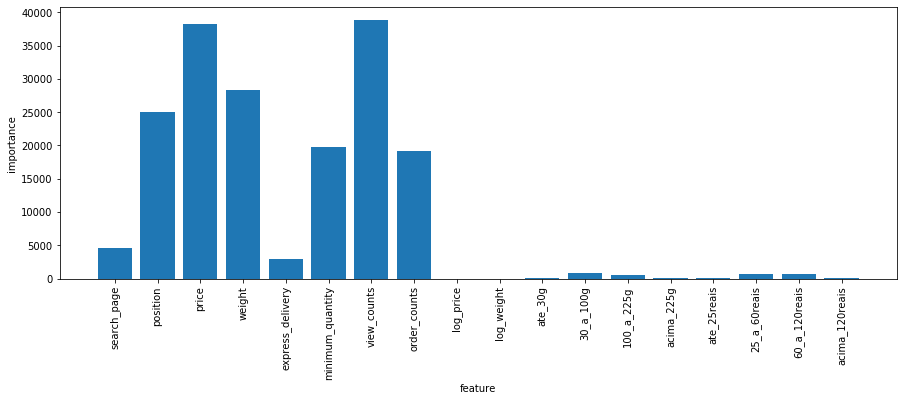

In [64]:
fig, axis = plt.subplots(figsize=(15, 5))
plot = axis.bar(X_train.columns, lgbm.feature_importances_)
plot = axis.set_xticklabels(X_train.columns.values, rotation='vertical')
plot = axis.set_xlabel('feature')
plot = axis.set_ylabel('importance')
plt.show()

# Avaliação do Sistema de Classificação

### Matriz de Confusão

Matriz de confusão é uma tabela com os erros de classificação do modelo. A tabela nos mostra a contagem de registros que eram da classe X (linha) e foram classificadas na classe Y (coluna). Em um problema de classificação binária, podemos ter 4 tipos de valores:

 - Verdadeiro Positivo (True Positive): É quando a classe prevista é igual a classe real. São os valores              representados pela diagonal principal da matriz. Exemplo, temos um sistema com falha e o modelo o classificou      como sistema com falha.


 - Falso Positivo (False Positive): É quando a classe prevista é diferente da classe real. Exemplo, temos um          sistema saudável, e o modelo o classificou como um sistema com falha.


 - Falso Verdadeiro (True Negative): É quando a classe prevista é igual a classe real, mas não é a classe que        queremos prever. Exemplo, temos um sistema saudável e o modelo o classificou como sistema saudável (lembrando      que nesse exemplo estamos buscando sistemas com falhas).


 - Falso Negativo (False Negative): Seguindo nesse exemplo, é quando o modelo classifica um sistema com falha como    um sistema saudável.


Isso faz muito sentido para um sistema binário. Para um sistema multiclasses, temos que olhar cada classe separadamente. Temos algumas métricas que são decorrentes da matriz de confusão, como os valores de precisão e recall. Esses valores são calculados da seguinte forma:


 - Precision = True Positive/(True Positive + False Positive)
 
 - Recall = True Positive/(True Positive + False Negative)
 
 - F-score = (2 * precision * recall)/(precision + recall)

Abaixo temos a matriz de Confusão do nosso modelo:

In [65]:
print('Matriz de Confusão Random Forest')
cm_rf =confusion_matrix(y_test, y_predict_rf)  
index = ['Bebê','Biju/Jóias','Decoração','Lembrancinhas','Papel/Cia','Outros']  
columns = ['Bebê','Biju/Jóias','Decoração','Lembrancinhas','Papel/Cia','Outros']  
cm_df_rf = pd.DataFrame(cm_rf,columns,index)                      
print(cm_df_rf)

Matriz de Confusão Random Forest
               Bebê  Biju/Jóias  Decoração  Lembrancinhas  Papel/Cia  Outros
Bebê            598           9        360            252         12       8
Biju/Jóias       49          52         40             26          5       1
Decoração       287          17       1109            188         18       8
Lembrancinhas   113           7        185           2754         22       4
Papel/Cia        56           2        117            258         41       7
Outros           24           2         74             83          4      18


Nessa matriz, temos que os resultados foram:

 - Classe Bebê: 593 registros foram classificadas corretamente, de um total de 1239 registros dessa classe.          Foram classificados como Bijuteria e Jóias 10 registros, 363 registros na classe Decoração, 252 na classe          Lembrancinhas, 13 na classe Papel/Cia e 8 na classe Outros. Essa é a terceira classe em relação à quantidade de    registros disponíveis.
 
 
 - Classe Bijuteria/Jóias: 51 registros foram classificados corretamente, de um total de 173 registros dessa          classe. Foram classificados como Bebê 51 registros, 39 registros na classe Decoração, 26 na classe                Lembrancinhas, 5 na classe Papel/Cia e 1 em Outros. Essa classe é a que menos possui quantidade de registros.
 
 
 - Classe Decaração: 1116 registros foram classificados corretamente, de um total de 1627 registros dessa            classe. Foram classificados como Bebê 282 registros, 17 na classe Bijuteria/Jóias, 187 na classe Lembrancinhas,    17 na classe Papel/Cia e 8 na classe Outros. Essa classe fica em segundo lugar em relação à quantidade de          registros disponíveis.
 
 
 - Classe Lembrancinhas: 2754 registros foram classificados corretamente, de um total de 3085 registros. Foram        classificados como Bebê 111 registros, 7 na classe Bijuteria/Jóias, 187 na classe Decoração, 22 na classe          Papel/Cia e 4 na classe Outros. Essa é a classe que possui o maior número de registros disponíveis.
 

 - Classe Papel e Cia: 41 registros foram classificados corretamente, de um total de 481 registros. Foram            classificados como Bebê 54 registros, 2 na classe Bijuteria/Jóias, 118 na classe Decoração, 259 na classe          Lembrancinhas e 7 na classe Outros. 


 - Classe Outros: 18 registros foram classificados corretamente, de um total de 205 registros. Foram                  classificados como Bebê 25 registros, 2 na classe Bijuteria/Jóias, 72 na classe Decoração, 89 na classe            Lembrancinhas e 4 na classe Papel e Cia.
 
 
Temos um conjunto de dados desbalanceado. O número de registros disponíveis para cada classe deveria ser igual. Temos um número muito grande de amostras para a classe Lembrancinhas, e um numero muito pequeno para a classe Bijuteria/Jóias.

Abaixo, seguimos a análise mostrando os valores de precisão, recall e f-score para cada classe.

In [66]:
print(classification_report(y_test, y_predict_rf, digits=3))

              precision    recall  f1-score   support

           1      0.531     0.483     0.505      1239
           2      0.584     0.301     0.397       173
           3      0.588     0.682     0.632      1627
           4      0.773     0.893     0.829      3085
           5      0.402     0.085     0.141       481
           6      0.391     0.088     0.143       205

    accuracy                          0.671      6810
   macro avg      0.545     0.422     0.441      6810
weighted avg      0.642     0.671     0.643      6810



A função classification_report nos mostra os valores de precisão, recall e f-score já calculados para cada classe. Os resultados são:

 - Classe Bebê: 
 
   - precision = (593)/(593 + 523) = 0.5314
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe Bebê, mas na       verdade são de outras classes (olhar os valores da coluna Bebê).
   
   - recall = (593)/(593 + 646) = 0.4786
   
     *Aqui os produtos da categoria Bebê que foram classificados como pertencentes a qualquer outra classe são           falsos negativos (olhar para a linha Bebê).
     
   - f-score = (2 * 0.5314 * 0.4786)/(0.5314 + 0.4786) = 0.5036
 
 
 - Classe Bijuteria/Jóias: 
  
   - precision = (51)/(51 + 38) = 0.573
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe                     Bijuteria/Jóias, mas na verdade são de outras classes (olhar os valores da coluna Bijuteria/Jóias).
   
   - recall = (51)/(51 + 122) = 0.2947
   
     *Aqui os produtos da categoria Bijuteria/Jóias que foram classificados como pertencentes a qualquer outra           classe são falsos negativos (olhar para a linha Bijuteria/Jóias).
     
   - f-score = (2 * 0.573 * 0.2947)/(0.573 + 0.2947) = 0.3893
 
 
 - Classe Decaração: 
 
   - precision = (1116)/(1116 + 779) = 0.5889
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe Decaração,         mas na verdade são de outras classes (olhar os valores da coluna Decaração).
   
   - recall = (1116)/(1116 + 511) = 0.6859
   
     *Aqui os produtos da categoria Decaração que foram classificados como pertencentes a qualquer outra classe         são falsos negativos (olhar para a linha Decaração).
     
   - f-score = (2 * 0.5889 * 0.6859)/(0.5889 + 0.6859) = 0.6337
 
 
 - Classe Lembrancinhas: 
 
   - precision = (2754)/(2754 + 808) = 0.7731
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe                     Lembrancinhas, mas na verdade são de outras classes (olhar os valores da coluna Lembrancinhas).
   
   - recall = (2754)/(2754 + 331) = 0.8927
   
     *Aqui os produtos da categoria Lembrancinhas que foram classificados como pertencentes a qualquer outra             classe são falsos negativos (olhar para a linha Lembrancinhas).
     
   - f-score = (2 * 0.7731 * 0.8927)/(0.7731 + 0.8927) = 0.8286
 
 
 - Classe Papel e Cia: 
 
   - precision = (41)/(41 + 61) = 0.4019
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe                     Papel e Cia, mas na verdade são de outras classes (olhar os valores da coluna Papel e Cia).
   
   - recall = (41)/(41 + 440) = 0.0852
   
     *Aqui os produtos da categoria Papel e Cia que foram classificados como pertencentes a qualquer outra             classe são falsos negativos (olhar para a linha Papel e Cia).
     
   - f-score = (2 * 0.4019 * 0.0852)/(0.4019 + 0.0852) = 0.1405
 
 
 - Classe Outros: 
 
   - precision = (18)/(18 + 28) = 0.3913
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe                     Outros, mas na verdade são de outras classes (olhar os valores da coluna Outros).
   
   - recall = (18)/(18 + 187) = 0.087
   
     *Aqui os produtos da categoria Outros que foram classificados como pertencentes a qualquer outra                   classe são falsos negativos (olhar para a linha Outros).
     
   - f-score = (2 * 0.3913 * 0.087)/(0.3913 + 0.087) = 0.1423




In [67]:
print('Matriz de Confusão LGBM ')
cm_lgbm =confusion_matrix(y_test, y_predict_lgbm)  
index = ['Bebê','Biju/Jóias','Decoração','Lembrancinhas','Papel/Cia','Outros']  
columns = ['Bebê','Biju/Jóias','Decoração','Lembrancinhas','Papel/Cia','Outros']  
cm_df_lgbm = pd.DataFrame(cm_lgbm,columns,index)                      
print(cm_df_lgbm)

Matriz de Confusão LGBM 
               Bebê  Biju/Jóias  Decoração  Lembrancinhas  Papel/Cia  Outros
Bebê            560          10        388            268          9       4
Biju/Jóias       45          43         51             26          5       3
Decoração       294           9       1094            199         20      11
Lembrancinhas   137           6        181           2716         38       7
Papel/Cia        47           2        124            257         47       4
Outros           30           3         70             81          5      16


In [68]:
print(classification_report(y_test, y_predict_lgbm, digits=3))

              precision    recall  f1-score   support

           1      0.503     0.452     0.476      1239
           2      0.589     0.249     0.350       173
           3      0.573     0.672     0.619      1627
           4      0.766     0.880     0.819      3085
           5      0.379     0.098     0.155       481
           6      0.356     0.078     0.128       205

    accuracy                          0.657      6810
   macro avg      0.528     0.405     0.425      6810
weighted avg      0.628     0.657     0.629      6810

